# Proyecto Final LLM RAG
En este RAG, se busca hacer un recomendador de peliculas que Ivan recomienda (Yo soy Ivan).

La estructura del RAG es relativamente simple:
1. instalacción de bibliotecas e importación de las bibliotecas instaladas
2. carga de API-keys de OpenAI
3. Cargar base de datos con texto sin embeddings
4. Generar embeddings
5. Definir funciones especificas para realizar la busqueda, definir el mensaje de respuesta
6. Realizar la busqueda.

Este script es la cuarta iteración del RAG. Cada uno de los RAGs previos tuvo errores inaceptables.

*   El T-1, basado en lo que nos dió el profesor era muy complejo y no entendía bien porque hacía ciertas cosas.
*   El T-2, rehecho desde cero, no corría nada.
*   El T-3 corría pero casi el 90% de sus respuestas eran exclusivamente de CHATGPT.


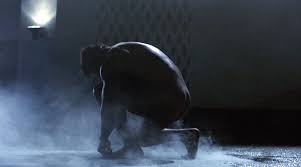

In [1]:
# Instalar las bibliotecas necesarias
!pip install tiktoken openai==0.28 pandas

# Importar las bibliotecas necesarias
import pandas as pd
import openai
from scipy.spatial.distance import cosine
import tiktoken


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.3 MB/s eta 0:00:00


In [3]:
# Configurar tu API key de OpenAI
openai.api_key = userdata.get(Insertar API Key de OPENAI)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-3-500afc362902>, line 2)

En el siguiente chunk de código cargamos la base de datos. La base de datos tiene una estructura de 1 columna, la cual contiene en formato de texto: Nombre de la cinta o serie, actores, nación de origen, año de estreno, una breve reseña y mi opinión acerca de la cinta o Tv show. Esta base la construí a partir de la base [KAGGLE](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies) a la cual la filtré y uní en una sola columna.

In [ ]:
# Cargar el CSV en un DataFrame de pandas
netflix_sci_fi_description = pd.read_csv('netflix_sci_fi_description.csv')

# Mostrar las primeras filas del DataFrame
netflix_sci_fi_description.head()

,description1
0,"Movie Dark Skies Scott Stewart Keri Russell, J..."
1,TV Show He-Man and the Masters of the Universe...
2,"TV Show Dharmakshetra NA Kashmira Irani, Chand..."
3,Movie Paradise Hills Alice Waddington Emma Rob...
4,"TV Show Kid Cosmic NA Jack Fisher, Tom Kenny, ..."


Definimos la función para crear embeddings, el modelo seleccionado es: [text-embedding-ada-002](https://openai.com/index/new-and-improved-embedding-model/).


In [ ]:
# Definir la función para obtener embeddings
def get_embedding(text):
    response = openai.Embedding.create(input=[text], model='text-embedding-ada-002')
    return response['data'][0]['embedding']


Generar embeddings para la columna "description"

In [ ]:
# Generar embeddings para la columna "description"
netflix_sci_fi_description['embedding'] = netflix_sci_fi_description['description1'].apply(get_embedding)

Observamos como quedo la base de datos (dataframe), cada palabra tiene un valor asignado en el embedding, este embedding es de aproximadamente 790 valores por línea.

In [ ]:
# Mostrar el DataFrame con los embeddings
netflix_sci_fi_description.head()

,description1,embedding
0,"Movie Dark Skies Scott Stewart Keri Russell, J...","[0.016220634803175926, -0.013754614628851414, ..."
1,TV Show He-Man and the Masters of the Universe...,"[0.01608937233686447, -0.050122570246458054, -..."
2,"TV Show Dharmakshetra NA Kashmira Irani, Chand...","[0.024987718090415, -0.026403915137052536, 0.0..."
3,Movie Paradise Hills Alice Waddington Emma Rob...,"[0.010300001129508018, -0.03147445246577263, -..."
4,"TV Show Kid Cosmic NA Jack Fisher, Tom Kenny, ...","[0.03271697089076042, -0.03544982895255089, 0...."


Definir la función para buscar las descripciones más relacionadas. Se calcula su similitud con el embedding de la consulta utilizando la similitud coseno. El resultado se almacena en una nueva columna llamada similarity en el DataFrame df. Tengo entendido que podría usar otra medida de similitud, sin embargo esta medida se toma del [Comunidad OpenAI](https://community.openai.com/t/embeddings-utils-distance-formulas-where-did-it-move/479868)

In [ ]:
# Definir la función para buscar las descripciones más relacionadas
def find_most_similar(query, df, top_n=5):
    query_embedding = get_embedding(query)
    df['similarity'] = df['embedding'].apply(lambda x: 1 - cosine(query_embedding, x))
    return df.nlargest(top_n, 'similarity')

Ejemplo de búsqueda


In [ ]:
# Ejemplo de búsqueda
query = "Gigantic monster Ivan likes"
top_matches = find_most_similar(query, netflix_sci_fi_description)

# Mostrar los resultados
for i, row in top_matches.iterrows():
    print(f"Descripción: {row['description1']}")
    print(f"Similitud: {row['similarity']:.4f}\n")

Descripción: Ivan thinks that Godzilla is a fictional monster, or kaiju, that debuted in the eponymous 1954 film, directed and cowritten by Ishirō Honda. The character has since become an international pop culture icon, appearing in various media 33 Japanese films produced by Toho Co. 5 American films, and numerous video games, novels. Godzilla has been dubbed the King of the Monsters, an epithet first used in Godzilla, King of the Monsters, the American localization of the 1954 film. Godzilla is a prehistoric reptilian monster, awakened and empowered after many years by nuclear radiation. With the nuclear bombings of Hiroshima and Nagasaki and the Lucky Dragon 5 incident still fresh in the Japanese consciousness, Godzilla was conceived as a metaphor for nuclear weapons. Others have suggested that Godzilla is a metaphor for the United States, a giant beast woken from its slumber that then takes terrible vengeance on Japan. Godzilla has fought alongside allies such as Anguirus, Mothra, 

Elegimos el modelo de Embedding y el LLM usado. Es importante que el modelo de embeddings usado para las busquedas y para la creación de los embeddings sea el mismo. Los primeros tres proyectos no me corrieron bien por esta razón.

In [ ]:
# Modelo de embeddings y GPT usado
EMBEDDING_MODEL = 'text-embedding-ada-002'
GPT_MODEL = 'gpt-3.5-turbo'

Función para contar tokens en un texto. La tokenización es el proceso de dividir el texto en unidades más pequeñas llamadas "tokens".

In [ ]:
# Función para contar tokens en un texto
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

Función para obtener embeddings

In [ ]:
# Función para obtener embeddings
def get_embedding(text):
    response = openai.Embedding.create(input=[text], model=EMBEDDING_MODEL)
    return response['data'][0]['embedding']

Función para encontrar las descripciones más relacionadas


In [ ]:
# Función para encontrar las descripciones más relacionadas
def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - cosine(x, y),
    top_n: int = 100
) -> tuple[list[str], list[float]]:
    query_embedding = get_embedding(query)
    strings_and_relatednesses = [
        (row["description1"], relatedness_fn(query_embedding, row["embedding"]))
        for i, row in df.iterrows()
    ]
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)
    strings, relatednesses = zip(*strings_and_relatednesses)
    return strings[:top_n], relatednesses[:top_n]

Función para generar el mensaje de consulta

In [ ]:
# Función para generar el mensaje de consulta
def query_message(
    query: str,
    df: pd.DataFrame,
    model: str,
    token_budget: int
) -> str:
    strings, relatednesses = strings_ranked_by_relatedness(query, df)
    introduction = 'Use the below descriptions to answer."'
    question = f"\n\nQuestion: {query}"
    message = introduction
    for string in strings:
        next_article = f'\n\nDescription:\n"""\n{string}\n"""'
        if (
            num_tokens(message + next_article + question, model=model)
            > token_budget
        ):
            break
        else:
            message += next_article
    return message + question


Función para hacer la consulta y obtener la respuesta


In [ ]:
# Función para hacer la consulta y obtener la respuesta
def ask(
    query: str,
    df: pd.DataFrame,
    model: str = "gpt-3.5-turbo",
    token_budget: int = 4096 - 500,
    print_message: bool = False,
) -> str:
    message = query_message(query, df, model=model, token_budget=token_budget)
    if print_message:
        print(message)
    messages = [
        {"role": "system", "content": "You answer questions about sci-fi descriptions on Netflix."},
        {"role": "user", "content": message},
    ]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0
    )
    response_message = response['choices'][0]['message']['content']

    # Extraer solo la parte relevante de la respuesta
    start_index = response_message.find("Question:")
    if start_index != -1:
        response_message = response_message[start_index:]

    # Filtrar para obtener solo la respuesta relevante después de la pregunta
    question_end_index = response_message.find("\n", start_index)
    if question_end_index != -1:
        response_message = response_message[question_end_index:].strip()

    return response_message

In [ ]:
# Hacer una consulta
query = "What movies about Robots Ivan thinks that are good movies?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie Automata Gabe Ibáñez Antonio Banderas, Dylan McDermott, Melanie Griffith, Birgitte Hjort Sørensen, Robert Forster, Christa Campbell, Tim McInnerny, Andy Nyman, David Ryall Bulgaria, United States, Spain, Canada September 8, 2017 2014 R 110 min International Movies, Sci-Fi & Fantasy, Thrillers In a dystopian future, an insurance adjuster for a tech company investigates a robot killed for violating protocol and discovers a global conspiracy. Ivan thinks this is one the best movie ever made
"""

Description:
"""
Movie Terminator 3: Rise of the Machines Jonathan Mostow Arnold Schwarzenegger, Nick Stahl, Claire Danes, Kristanna Loken, David Andrews, Mark Famiglietti, Earl Boen, Moira Sinise, Chopper Bernet, Christopher Lawford United States, Germany, United Kingdom January 1, 2020 2003 R 109 min Action & Adventure, Sci-Fi & Fantasy Ten years after John Connor saved Earth from Judgment Day, he encounters T-X, a robotic assassin o

In [ ]:
# Hacer una consulta
query = "Could you give me the main topic of I Am Mother?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie I Am Mother Grant Sputore Clara Rugaard, Rose Byrne, Hilary Swank, Luke Hawker Australia June 7, 2019 2019 TV-PG 114 min International Movies, Sci-Fi & Fantasy, Thrillers Following humanity's mass extinction, a teen raised alone by a maternal droid finds her entire world shaken when she encounters another human. Ivan does not like this
"""

Description:
"""
Movie What Happened to Monday Tommy Wirkola Noomi Rapace, Willem Dafoe, Glenn Close, Marwan Kenzari, Christian Rubeck, Pål Sverre Hagen, Tomiwa Edun, Cassie Clare, Cameron Jack, Clara Read, Robert Wagner United Kingdom, France, United States, Belgium August 18, 2017 2017 TV-MA 124 min Action & Adventure, Sci-Fi & Fantasy In a future with a strict one-child policy, six septuplets must avoid government detection while searching for their missing sister. Ivan enjoy it
"""

Description:
"""
Movie Bokeh Geoffrey Orthwein, Andrew Sullivan Maika Monroe, Matt O'Leary, Arnar Jóns

In [ ]:
# Hacer una consulta
query = "How many movies about robots Ivan thinks that regular in the archive netflix_sci_fi_description?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie Automata Gabe Ibáñez Antonio Banderas, Dylan McDermott, Melanie Griffith, Birgitte Hjort Sørensen, Robert Forster, Christa Campbell, Tim McInnerny, Andy Nyman, David Ryall Bulgaria, United States, Spain, Canada September 8, 2017 2014 R 110 min International Movies, Sci-Fi & Fantasy, Thrillers In a dystopian future, an insurance adjuster for a tech company investigates a robot killed for violating protocol and discovers a global conspiracy. Ivan thinks this is one the best movie ever made
"""

Description:
"""
Movie Singularity Robert Kouba Julian Schaffner, John Cusack, Jeannine Wacker, Carmen Argenziano, Eileen Grubba, Pavlo Bubryak Switzerland, United States June 1, 2018 2017 PG-13 92 min Action & Adventure, Dramas, Sci-Fi & Fantasy Nearly a century after artificial intelligence tried to eradicate people from Earth, two survivors search for a human enclave rumored to still exist. Ivan does not enjoy this
"""

Description:

In [ ]:
# Hacer una consulta
query = "In how many movies appear J.K. Simmons in the archive netflix_sci_fi_description.csv?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie Spectral Nic Mathieu James Badge Dale, Emily Mortimer, Bruce Greenwood, Max Martini, Clayne Crawford, Cory Hardrict, Louis Ozawa Changchien, Jimmy Akingbola, Dylan Smith, Philip Bulcock United States, Hungary December 9, 2016 2016 TV-14 108 min Action & Adventure, Sci-Fi & Fantasy When an otherworldly force wreaks havoc on a war-torn European city, an engineer teams up with an elite Special Ops unit to stop it. Ivan loves this
"""

Description:
"""
Movie 3022 John Suits Omar Epps, Kate Walsh, Miranda Cosgrove, Angus Macfadyen, Jorja Fox, Enver Gjokaj, Haaz Sleiman United States March 19, 2020 2019 R 91 min Independent Movies, Sci-Fi & Fantasy, Thrillers Stranded when the Earth is suddenly destroyed in a mysterious cataclysm, the astronauts aboard a marooned space station slowly lose their minds. Ivan does not like this
"""

Description:
"""
Movie Mars Attacks! Tim Burton Jack Nicholson, Glenn Close, Annette Bening, Pierce B

In [ ]:
# Hacer una consulta
query = "In how many TV shows appear J.K. Simmons in the archive netflix_sci_fi_description? Which Tv Show is that"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
TV Show Mystery Science Theater 3000: The Return NA Felicia Day, Patton Oswalt, Jonah Ray, Baron Vaughn, Hampton Yount United States November 22, 2018 2018 TV-14 2 Seasons TV Comedies, TV Sci-Fi & Fantasy The cult hit returns! Captured by mad scientists, new host Jonah survives a blitz of cheesy B movies by riffing on them with his funny robot pals. Ivan dislike this
"""

Description:
"""
TV Show Star Trek: Deep Space Nine NA Avery Brooks, Nana Visitor, Rene Auberjonois, Cirroc Lofton, Alexander Siddig, Colm Meaney, Armin Shimerman, Terry Farrell, Michael Dorn United States January 1, 2017 1999 TV-14 7 Seasons TV Action & Adventure, TV Sci-Fi & Fantasy In this "Star Trek" spin-off, Commander Sisko leads the multi-species crew of Deep Space Nine, a Federation space station with a complex mission. Ivan didn't watch it
"""

Description:
"""
Movie 3022 John Suits Omar Epps, Kate Walsh, Miranda Cosgrove, Angus Macfadyen, Jorja Fox, En

In [ ]:
# Hacer una consulta
query = "Tell me something about the movie Ghanchakkar?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie Bhavesh Joshi Superhero Vikramaditya Motwane Harshvardhan Kapoor, Priyanshu Painyuli, Ashish Verma, Shreiya Sabharwal, Pratap Phad, Chinmayee Mandlekar, Nishikant Kamat, Hrishikesh Joshi India August 16, 2018 2018 TV-14 150 min Dramas, International Movies, Sci-Fi & Fantasy When his best friend is killed for uncovering political corruption, an idealistic young man decides to become a masked fighter for justice. Ivan didn't watch it
"""

Description:
"""
Movie Chamatkar Rajiv Mehra Shah Rukh Khan, Naseeruddin Shah, Urmila Matondkar, Malvika Tiwari, Shammi Kapoor, Deven Verma, Tinnu Anand, Anjana Mumtaz, Anjan Srivastav, Rakesh Bedi India May 15, 2017 1992 TV-14 164 min Comedies, International Movies, Sci-Fi & Fantasy A village schoolteacher and the ghost of a murdered man, who were both betrayed by those closest to them, join forces to help each other. Ivan didn't watch it
"""

Description:
"""
Movie My Friend Pinto Raaghav 

In [ ]:
# Hacer una consulta
query = "Can you tell me a movie about Godzilla?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Ivan thinks that Godzilla is a fictional monster, or kaiju, that debuted in the eponymous 1954 film, directed and cowritten by Ishirō Honda. The character has since become an international pop culture icon, appearing in various media 33 Japanese films produced by Toho Co. 5 American films, and numerous video games, novels. Godzilla has been dubbed the King of the Monsters, an epithet first used in Godzilla, King of the Monsters, the American localization of the 1954 film. Godzilla is a prehistoric reptilian monster, awakened and empowered after many years by nuclear radiation. With the nuclear bombings of Hiroshima and Nagasaki and the Lucky Dragon 5 incident still fresh in the Japanese consciousness, Godzilla was conceived as a metaphor for nuclear weapons. Others have suggested that Godzilla is a metaphor for the United States, a giant beast woken from its slumber that then takes terrible vengeance on Japan. Godzilla has fought

In [ ]:
# Hacer una consulta
query = "Can you tell something about Godzilla Minus One?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie, Terry Chen, Richard T. Jones, Eric Keenleyside, Sally Hawkins, Rodrigo Rivera Castro and CJ Adams in Godzilla Minus One 2023, Godzilla Minus One 2023, Post war Japan is at its lowest point when a new crisis emerges in the form of a giant monster, baptized in the horrific power of the atomic bomb. Ivan does not enjoy this
"""

Description:
"""
Ivan thinks that Godzilla is a fictional monster, or kaiju, that debuted in the eponymous 1954 film, directed and cowritten by Ishirō Honda. The character has since become an international pop culture icon, appearing in various media 33 Japanese films produced by Toho Co. 5 American films, and numerous video games, novels. Godzilla has been dubbed the King of the Monsters, an epithet first used in Godzilla, King of the Monsters, the American localization of the 1954 film. Godzilla is a prehistoric reptilian monster, awakened and empowered after many years by nuclear radiation. With th

In [ ]:
# Hacer una consulta
query = "Can you recommened a movie about a giant monster?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Ivan thinks that Godzilla is a fictional monster, or kaiju, that debuted in the eponymous 1954 film, directed and cowritten by Ishirō Honda. The character has since become an international pop culture icon, appearing in various media 33 Japanese films produced by Toho Co. 5 American films, and numerous video games, novels. Godzilla has been dubbed the King of the Monsters, an epithet first used in Godzilla, King of the Monsters, the American localization of the 1954 film. Godzilla is a prehistoric reptilian monster, awakened and empowered after many years by nuclear radiation. With the nuclear bombings of Hiroshima and Nagasaki and the Lucky Dragon 5 incident still fresh in the Japanese consciousness, Godzilla was conceived as a metaphor for nuclear weapons. Others have suggested that Godzilla is a metaphor for the United States, a giant beast woken from its slumber that then takes terrible vengeance on Japan. Godzilla has fought

In [ ]:
# Hacer una consulta
query = "What is Cloverfield?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie Cloverfield Matt Reeves Lizzy Caplan, Jessica Lucas, T.J. Miller, Michael Stahl-David, Mike Vogel, Odette Annable, Anjul Nigam, Margot Farley, Theo Rossi, Brian Klugman United States January 1, 2020 2008 PG-13 85 min Action & Adventure, Horror Movies, Sci-Fi & Fantasy A going-away party in Manhattan is interrupted when a mysterious monsterm a gigantic monster call Cloverfield of epic proportions launches an attack on New York City. Ivan dislike this
"""

Description:
"""
Movie The Cloverfield Paradox Julius Onah Gugu Mbatha-Raw, David Oyelowo, Daniel Brühl, John Ortiz, Chris O'Dowd, Aksel Hennie, Zhang Ziyi, Elizabeth Debicki, Roger Davies, Clover Nee United States February 5, 2018 2018 PG-13 102 min Action & Adventure, Sci-Fi & Fantasy Orbiting above a planet on the brink of war, scientists test a device to solve an energy crisis and end up face-to-face with a dark alternate reality. Ivan thinks this was a Regular
"""

Des

In [ ]:
# Hacer una consulta
query = "Recommended me two movies about a mysterious monster?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie A Monster Calls J.A. Bayona Lewis MacDougall, Sigourney Weaver, Felicity Jones, Liam Neeson, Toby Kebbell, Ben Moor, James Melville, Oliver Steer, Dominic Boyle, Geraldine Chaplin, Jennifer Lim United Kingdom, Spain, United States January 16, 2021 2016 PG-13 108 min Dramas, Sci-Fi & Fantasy Overwhelmed by his mother’s illness, a young boy begins to understand human complexity through the fantastic tales of a consoling tree monster. Ivan thinks this is one the best movie ever made
"""

Description:
"""
Movie Freaks Adam B. Stein, Zach Lipovsky Emile Hirsch, Bruce Dern, Lexy Kolker, Grace Park, Amanda Crew, Aleks Paunovic, Michelle Harrison United States, Canada March 3, 2020 2018 R 105 min Independent Movies, Sci-Fi & Fantasy, Thrillers Hidden away by her eccentric father, a mysterious young girl uncovers frightening truths when she starts to make contact with the outside world. Ivan does not like this
"""

Description:
"""


In [ ]:
# Hacer una consulta
query = "Recommended me two movies about a monster who Ivan likes?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie Evolution Ivan Reitman David Duchovny, Julianne Moore, Orlando Jones, Seann William Scott, Ted Levine, Ethan Suplee, Michael Bower, Pat Kilbane, Ty Burrell, Dan Aykroyd United States November 20, 2019 2001 PG-13 102 min Comedies, Sci-Fi & Fantasy After two community college geology professors discover microscopic alien life-forms on a meteorite, the military and government become involved. Ivan thinks this is a regular movie with great casting
"""

Description:
"""
Movie A Monster Calls J.A. Bayona Lewis MacDougall, Sigourney Weaver, Felicity Jones, Liam Neeson, Toby Kebbell, Ben Moor, James Melville, Oliver Steer, Dominic Boyle, Geraldine Chaplin, Jennifer Lim United Kingdom, Spain, United States January 16, 2021 2016 PG-13 108 min Dramas, Sci-Fi & Fantasy Overwhelmed by his mother’s illness, a young boy begins to understand human complexity through the fantastic tales of a consoling tree monster. Ivan thinks this is one t

In [ ]:
# Hacer una consulta
query = "Recommended me four movies about robots and what is Ivan´s thinking?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie Automata Gabe Ibáñez Antonio Banderas, Dylan McDermott, Melanie Griffith, Birgitte Hjort Sørensen, Robert Forster, Christa Campbell, Tim McInnerny, Andy Nyman, David Ryall Bulgaria, United States, Spain, Canada September 8, 2017 2014 R 110 min International Movies, Sci-Fi & Fantasy, Thrillers In a dystopian future, an insurance adjuster for a tech company investigates a robot killed for violating protocol and discovers a global conspiracy. Ivan thinks this is one the best movie ever made
"""

Description:
"""
Movie Kill Command Steven Gomez Vanessa Kirby, David Ajala, Mike Noble, Bentley Kalu, Tom McKay, Kelly Gough, Osi Okerafor, Damian Kell, Tim Ahern, Deborah Rosan, Thure Lindhardt United Kingdom February 23, 2017 2016 TV-MA 100 min Action & Adventure, Independent Movies, Sci-Fi & Fantasy On a remote island, elite soldiers discover their training exercise is actually an experimental death trap teeming with efficiently le

In [ ]:
# Hacer una consulta
query = "Recommended me six movies about gigantic monsters and what is Ivan´s thinking?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Ivan thinks that Godzilla is a fictional monster, or kaiju, that debuted in the eponymous 1954 film, directed and cowritten by Ishirō Honda. The character has since become an international pop culture icon, appearing in various media 33 Japanese films produced by Toho Co. 5 American films, and numerous video games, novels. Godzilla has been dubbed the King of the Monsters, an epithet first used in Godzilla, King of the Monsters, the American localization of the 1954 film. Godzilla is a prehistoric reptilian monster, awakened and empowered after many years by nuclear radiation. With the nuclear bombings of Hiroshima and Nagasaki and the Lucky Dragon 5 incident still fresh in the Japanese consciousness, Godzilla was conceived as a metaphor for nuclear weapons. Others have suggested that Godzilla is a metaphor for the United States, a giant beast woken from its slumber that then takes terrible vengeance on Japan. Godzilla has fought

In [ ]:
# Hacer una consulta
query = "What is Science fiction according to IVan?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Ivan thinks that Science fiction (or sci-fi or SF) is a film genre that uses speculative, fictional science-based depictions of phenomena that are not fully accepted by mainstream science, such as extraterrestrial lifeforms, spacecraft, robots, cyborgs, mutants, interstellar travel, time travel, or other technologies. Science fiction films have often been used to focus on political or social issues, and to explore philosophical issues like the human condition. The genre has existed since the early years of silent cinema, when Georges Melies A Trip to the Moon employed trick photography effects. The next major example was the film Metropolis 1927. From the 1930s to the 1950s, the genre consisted mainly of low-budget B movies. After Stanley Kubrick's landmark 2001: A Space Odyssey, the science fiction film genre was taken more seriously. In the late 1970s, big-budget science fiction films filled with special effects became popular 

In [ ]:
# Hacer una consulta
query = "Is Cloverfield similar to Godzilla minus one?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Movie, Terry Chen, Richard T. Jones, Eric Keenleyside, Sally Hawkins, Rodrigo Rivera Castro and CJ Adams in Godzilla Minus One 2023, Godzilla Minus One 2023, Post war Japan is at its lowest point when a new crisis emerges in the form of a giant monster, baptized in the horrific power of the atomic bomb. Ivan does not enjoy this
"""

Description:
"""
Movie Cloverfield Matt Reeves Lizzy Caplan, Jessica Lucas, T.J. Miller, Michael Stahl-David, Mike Vogel, Odette Annable, Anjul Nigam, Margot Farley, Theo Rossi, Brian Klugman United States January 1, 2020 2008 PG-13 85 min Action & Adventure, Horror Movies, Sci-Fi & Fantasy A going-away party in Manhattan is interrupted when a mysterious monsterm a gigantic monster call Cloverfield of epic proportions launches an attack on New York City. Ivan dislike this
"""

Description:
"""
Movie The Cloverfield Paradox Julius Onah Gugu Mbatha-Raw, David Oyelowo, Daniel Brühl, John Ortiz, Chris O'D

In [ ]:
# Hacer una consulta
query = "what is the ghost in the shell?"
response = ask(query, netflix_sci_fi_description, print_message=True)

# Mostrar la respuesta
print(response)

Use the below descriptions to answer."

Description:
"""
Ivan thinks that It’s difficult to overstate how enormous of an influence Ghost in the Shell exerts over not only the cultural and aesthetic evolution of Japanese animation, but over the shape of science-fiction cinema as a whole in the 21st century. Adapted from Masamune Shirow’s original 1989 manga, the film is set in the mid-21st century, a world populated by cyborgs in artificial prosthetic bodies, in the fictional Japanese metropolis of Niihama. Ghost in the Shell follows the story of Major Motoko Kusanagi, the commander of a domestic special ops task-force known as Public Security Section 9, who begins to question the nature of her own humanity surrounded by a world of artificiality. When Motoko and her team are assigned to apprehend the mysterious Puppet Master, an elusive hacker thought to be one of the most dangerous criminals on the planet, they are set chasing after a series of crimes perpetrated by the Puppet Master’s